In [129]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib
import warnings
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [130]:
warnings.simplefilter('ignore')


In [131]:
df = pd.read_csv('thyroid_cancer_risk_data.csv')
df.drop(columns=['Patient_ID', 'Age', 'Country', 'Ethnicity'], axis=1, inplace=True)
df.head()

,Gender,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,Male,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,Male,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,Male,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,Female,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,Female,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


In [132]:
ohe_encoding = OneHotEncoder(drop="first", sparse_output=False)
encoded_cols = ["Gender"]
df_ohe_encoding = pd.DataFrame(ohe_encoding.fit_transform(df[encoded_cols]), columns=ohe_encoding.get_feature_names_out(encoded_cols))

In [133]:
ord_encoding = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
df['Thyroid_Cancer_Risk'] = ord_encoding.fit_transform(df[['Thyroid_Cancer_Risk']])

df = df.drop(columns=encoded_cols).join(df_ohe_encoding)

df['Diagnosis'] = df['Diagnosis'].map({'Benign' : 0, 'Malignant' : 1})

In [134]:
binary_cols = ['Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes']
df[binary_cols] = df[binary_cols].replace({'Yes' : 1, 'No' : 0}).astype(int)

In [135]:
df

,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis,Gender_Male
0,0,1,0,0,0,0,9.37,1.67,6.16,1.08,0.0,0,1.0
1,0,1,0,0,0,0,1.83,1.73,10.54,4.05,0.0,0,1.0
2,0,0,0,0,0,0,6.26,2.59,10.57,4.61,0.0,0,1.0
3,0,0,0,0,0,0,4.10,2.62,11.04,2.46,1.0,0,0.0
4,1,1,0,0,0,0,9.10,2.11,10.71,2.11,2.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212686,0,0,0,0,1,0,2.00,0.64,11.92,1.48,0.0,0,0.0
212687,0,0,0,0,1,0,9.77,3.25,7.30,4.46,1.0,0,1.0
212688,0,0,0,0,0,1,7.72,2.44,8.71,2.36,1.0,0,0.0
212689,0,0,0,0,0,1,5.62,2.53,9.62,1.54,1.0,0,0.0


## Train test & split

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

df_resultats = pd.DataFrame()


X = df.drop(columns='Diagnosis')
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Logistic regression

In [137]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=42, n_jobs=-1)

score = cross_val_score(model_lr, X, y, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')

df_resultats['lr_score'] = score

Score des validations croisées [0.826089   0.82824768 0.82709577 0.82850628 0.82683718]
Score moyen : 0.8273551831820928


In [138]:
clf_lr = GridSearchCV(cv=5, estimator=LogisticRegression(), param_grid={'max_iter' :[100,200,500], 'C' : [0.01, 0.1, 1, 10, 100]},scoring='roc_auc', verbose=1, n_jobs=-1)

clf_lr.fit(X_train, y_train)

print(f'Meilleurs paramètres : {clf_lr.best_params_}')
print(f'Meilleur score AUC : {clf_lr.best_score_}')
print(f'Meilleur estimateur : {clf_lr.best_estimator_}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Meilleurs paramètres : {'C': 100, 'max_iter': 100}
Meilleur score AUC : 0.6972880715273437
Meilleur estimateur : LogisticRegression(C=100)


In [139]:
joblib.dump(clf_lr.best_estimator_, 'pred_cancer_logistic_regression.joblib')
print("Model save sous 'pred_cancer_logistic_regression.pkl'")

Model save sous 'pred_cancer_logistic_regression.pkl'


Accuracy : 0.8260838592941914
AUC : 0.6956875219492021


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.69      0.45      0.55     16302

    accuracy                           0.83     70189
   macro avg       0.77      0.69      0.72     70189
weighted avg       0.81      0.83      0.81     70189

Matrice de confusion


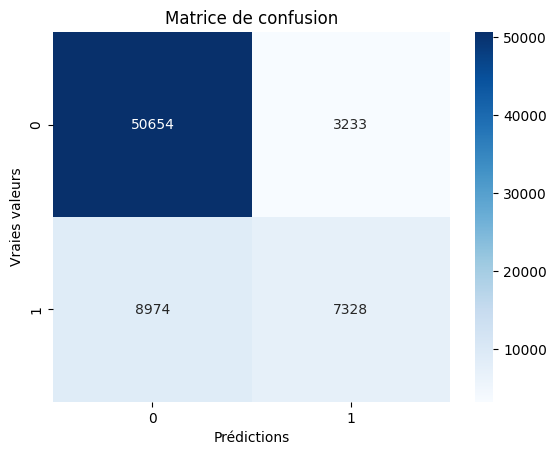

Matrice de confusion : 
[[50654  3233]
 [ 8974  7328]]


In [140]:
best_lr_model = clf_lr.best_estimator_
y_pred = best_lr_model.predict(X_test)
y_proba = best_lr_model.predict_proba(X_test)[:,1]


print(f'Accuracy : {accuracy_score(y_test, y_pred)}')

print(f'AUC : {roc_auc_score(y_test, y_proba)}')

print(f'\n\nClassification report : \n{classification_report(y_test, y_pred)}')

print(f'Matrice de confusion')


confusion_matrix_graph = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred)}')

## Polynomial regression

In [141]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)

score = cross_val_score(model_lr, X_train_poly, y_train, cv=5, n_jobs=-1)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')
df_resultats['polynomial_features'] = score

Score des validations croisées [0.82695344 0.82863759 0.82901754 0.82603509 0.82926316]
Score moyen : 0.8279813642734604


In [142]:
clf_poly = GridSearchCV(cv=5, estimator=LogisticRegression(), param_grid={'max_iter' :[100,200,500], 'C' : [0.001, 0.01, 0.1, 1, 10]},scoring='roc_auc', verbose=1, n_jobs=-1)
clf_poly.fit(X_train_poly, y_train)

print(f'Meilleurs paramètres : {clf_poly.best_params_}')
print(f'Meilleur score AUC : {clf_poly.best_score_}')
print(f'Meilleur estimateur : {clf_poly.best_estimator_}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Meilleurs paramètres : {'C': 0.01, 'max_iter': 200}
Meilleur score AUC : 0.6983039398651959
Meilleur estimateur : LogisticRegression(C=0.01, max_iter=200)


Accuracy : 0.8260838592941914
AUC : 0.695776393927398


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.69      0.45      0.55     16302

    accuracy                           0.83     70189
   macro avg       0.77      0.69      0.72     70189
weighted avg       0.81      0.83      0.81     70189

Matrice de confusion : 
[[50654  3233]
 [ 8974  7328]]
Matrice de confusion


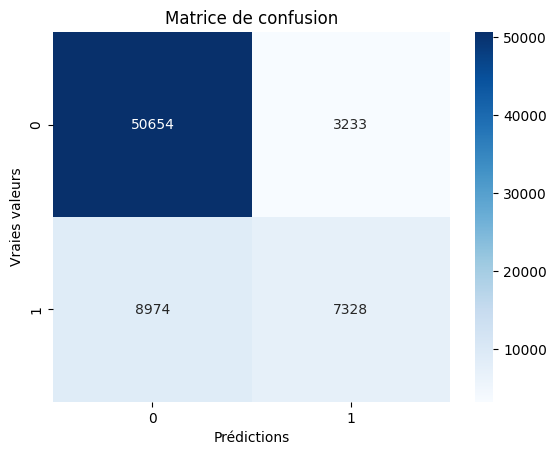

In [143]:
model_poly_lr = clf_poly.best_estimator_

X_test_poly = poly.transform(X_test)

y_pred = model_poly_lr.predict(X_test_poly)
y_proba = model_poly_lr.predict_proba(X_test_poly)[:,1]


print(f'Accuracy : {accuracy_score(y_test, y_pred)}')
print(f'AUC : {roc_auc_score(y_test, y_proba)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred)}')

print(f'Matrice de confusion')
confusion_matrix_graph = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

# print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred)}')

## Random Forest regression

In [144]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced', n_jobs=-1)

score = cross_val_score(model_rf, X, y, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')

Score des validations croisées [0.82199864 0.82364004 0.82326391 0.82401617 0.82309935]
Score moyen : 0.8232036202988547


### avec gridsearch

In [145]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    }

clf_random_f = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced_subsample'), param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

clf_random_f.fit(X_train, y_train)

print(f'Meilleurs paramètres : {clf_random_f.best_params_}')
print(f'Meilleur score AUC : {clf_random_f.best_score_}')
print(f'Meilleur estimateur : {clf_random_f.best_estimator_}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs paramètres : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Meilleur score AUC : 0.6983076901699458
Meilleur estimateur : RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_split=5, n_estimators=200, random_state=42)


In [146]:
joblib.dump(clf_random_f.best_estimator_, 'pred_cancer_random_forest_model_classifier.joblib')
print("Model save sous 'pred_cancer_random_forest_model_classifier.pkl'")

Model save sous 'pred_cancer_random_forest_model_classifier.pkl'


Accuracy : 0.8260268703073131
AUC : 0.6945300933795864


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.69      0.45      0.55     16302

    accuracy                           0.83     70189
   macro avg       0.77      0.69      0.72     70189
weighted avg       0.81      0.83      0.81     70189

Matrice de confusion : 
[[50659  3228]
 [ 8983  7319]]
Matrice de confusion


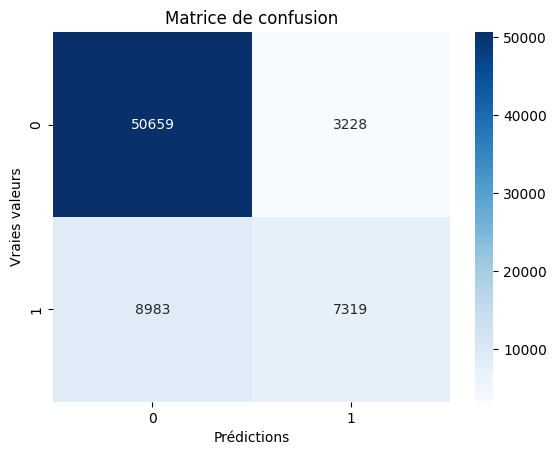

In [147]:
model_rf_best = clf_random_f.best_estimator_
y_pred_random_f = model_rf_best.predict(X_test)


print(f'Accuracy : {accuracy_score(y_test, y_pred_random_f)}')
print(f'AUC : {roc_auc_score(y_test, y_pred_random_f)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_random_f)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_random_f)}')

print(f'Matrice de confusion')
confusion_matrix_graph = confusion_matrix(y_test, y_pred_random_f)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

# print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_random_f)}')

### avec randomizedsearch pour gagner du temps d'éxécution

In [148]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

clf_rf_randomized = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20, 
    cv=5, 
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

clf_rf_randomized.fit(X_train, y_train)
print(f'Meilleurs paramètres : {clf_rf_randomized.best_params_}')
print(f'Meilleur score AUC : {clf_rf_randomized.best_score_}')
print(f'Meilleur estimateur : {clf_rf_randomized.best_estimator_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres : {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 51}
Meilleur score AUC : 0.6981523924500899
Meilleur estimateur : RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       max_features='log2', min_samples_leaf=8,
                       min_samples_split=5, n_estimators=51, n_jobs=-1,
                       random_state=42)


Accuracy : 0.8260696120474719
AUC : 0.694750461074826


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.69      0.45      0.55     16302

    accuracy                           0.83     70189
   macro avg       0.77      0.69      0.72     70189
weighted avg       0.81      0.83      0.81     70189

Matrice de confusion : 
[[50653  3234]
 [ 8974  7328]]
Matrice de confusion


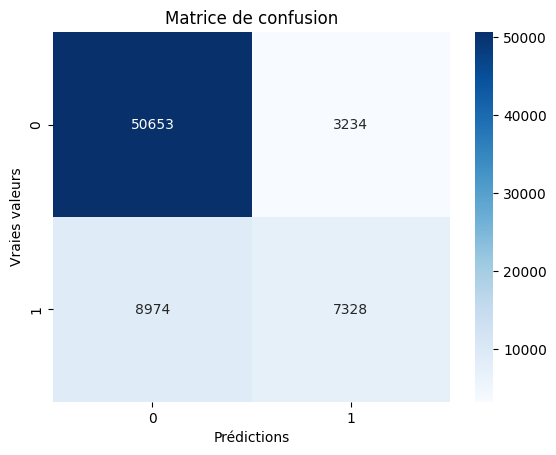

In [149]:
model_rf_randomized = clf_rf_randomized.best_estimator_

y_pred_rf_randomized = model_rf_randomized.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred_rf_randomized)}')
print(f'AUC : {roc_auc_score(y_test, y_pred_rf_randomized)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_rf_randomized)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_rf_randomized)}')

print(f'Matrice de confusion')
confusion_matrix_graph = confusion_matrix(y_test, y_pred_rf_randomized)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

## KNN

In [150]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model_knn = KNeighborsClassifier(n_jobs=-1)

score = cross_val_score(model_knn, X_train_scaled, y_train, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')

df_resultats['knn'] = score

Score des validations croisées [0.8010947  0.80070875 0.80126316 0.79968421 0.80336842]
Score moyen : 0.8012238469933649


In [151]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': range(5, 51, 5),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'] 
}

clf_knn = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
clf_knn.fit(X_train, y_train)

print(f'Meilleurs paramètres : {clf_knn.best_params_}')
print(f'Meilleur score AUC : {clf_knn.best_score_}')
print(f'Meilleur estimateur : {clf_knn.best_estimator_}')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Meilleurs paramètres : {'knn__metric': 'manhattan', 'knn__n_neighbors': 35, 'knn__weights': 'uniform'}
Meilleur score AUC : 0.7001162875490489
Meilleur estimateur : Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=35))])


In [152]:
joblib.dump(clf_knn.best_estimator_, 'pred_cancer_knn.joblib')
print("Model save sous 'pred_cancer_knn.pkl'")

Model save sous 'pred_cancer_knn.pkl'


Accuracy : 0.824302953454245
AUC : 0.6977704582978485


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.69      0.44      0.54     16302

    accuracy                           0.82     70189
   macro avg       0.77      0.69      0.71     70189
weighted avg       0.81      0.82      0.81     70189

Matrice de confusion : 
[[50759  3128]
 [ 9204  7098]]
Matrice de confusion


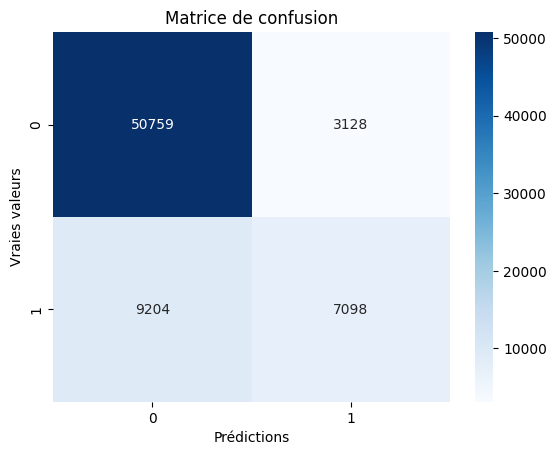

In [153]:
model_knn = clf_knn.best_estimator_

y_pred_knn = model_knn.predict(X_test)
y_proba_knn = model_knn.predict_proba(X_test)[:,1]

print(f'Accuracy : {accuracy_score(y_test, y_pred_knn)}')
print(f'AUC : {roc_auc_score(y_test, y_proba_knn)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_knn)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_knn)}')

print(f'Matrice de confusion')
confusion_matrix_graph = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

# print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred)}')

## Decision Tree

In [154]:
from sklearn.tree import DecisionTreeClassifier

model_decision_tree = DecisionTreeClassifier(random_state=42)

score = cross_val_score(model_decision_tree, X, y, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')

df_resultats['decision_tree'] = score

Score des validations croisées [0.70373069 0.70536932 0.70680333 0.7070149  0.70417039]
Score moyen : 0.7054177265941315


In [155]:
clf_decision_tree = GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), param_grid={'max_depth' :[1,2,3,4,5,6,7,8,9,10], 'criterion' : ['gini', 'entropy']},scoring='roc_auc', verbose=1, n_jobs=-1)
clf_decision_tree.fit(X_train, y_train)

print(f'Meilleurs paramètres : {clf_decision_tree.best_params_}')
print(f'Meilleur score AUC : {clf_decision_tree.best_score_}')
print(f'Meilleur estimateur : {clf_decision_tree.best_estimator_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres : {'criterion': 'entropy', 'max_depth': 2}
Meilleur score AUC : 0.6992229762040398
Meilleur estimateur : DecisionTreeClassifier(criterion='entropy', max_depth=2)


In [156]:
joblib.dump(clf_decision_tree.best_estimator_, 'pred_cancer_decision_tree.joblib')
print("Model save sous 'pred_cancer_decision_tree.pkl'")

Model save sous 'pred_cancer_decision_tree.pkl'


Accuracy : 0.8260838592941914
AUC : 0.6947597397505734


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.69      0.45      0.55     16302

    accuracy                           0.83     70189
   macro avg       0.77      0.69      0.72     70189
weighted avg       0.81      0.83      0.81     70189

Matrice de confusion : 
[[50654  3233]
 [ 8974  7328]]
Matrice de confusion


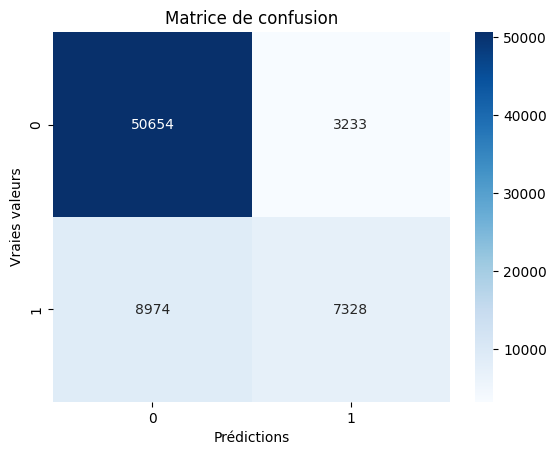

In [157]:
model_decision_tree = clf_decision_tree.best_estimator_

y_pred_decision_tree = model_decision_tree.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred_decision_tree)}')
print(f'AUC : {roc_auc_score(y_test, y_pred_decision_tree)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_decision_tree)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_decision_tree)}')

print(f'Matrice de confusion')

confusion_matrix_graph = confusion_matrix(y_test, y_pred_decision_tree)

sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

## LightGBM

In [158]:
import lightgbm as lgb

model_lgbm = lgb.LGBMClassifier(random_state=42)

score = cross_val_score(model_lgbm, X, y, cv=5)

print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')
df_resultats['lightgbm'] = score

[LightGBM] [Info] Number of positive: 39596, number of negative: 130556
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 170152, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232710 -> initscore=-1.193074
[LightGBM] [Info] Start training from score -1.193074
[LightGBM] [Info] Number of positive: 39596, number of negative: 130557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 170153, number of used features: 12
[LightGBM] [In

In [159]:
from scipy.stats import randint, uniform

param_dist = {
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 500),
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_lambda': uniform(0, 10),
    'reg_alpha': uniform(0, 10)
}

clf_lgb = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20, 
    cv=5, 
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

clf_lgb.fit(X_train, y_train)

print(f'Meilleurs paramètres : {clf_lgb.best_params_}')
print(f'Meilleur score AUC : {clf_lgb.best_score_}')
print(f'Meilleur estimateur : {clf_lgb.best_estimator_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 33193, number of negative: 109309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 142502, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [160]:
joblib.dump(clf_lgb.best_estimator_, 'pred_cancer_light_gbm.joblib')
print("Model save sous 'pred_cancer_light_gbm.pkl'")

Model save sous 'pred_cancer_light_gbm.pkl'


Accuracy : 0.8230776902363618
AUC : 0.6937645975078596


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.68      0.45      0.54     16302

    accuracy                           0.82     70189
   macro avg       0.76      0.69      0.72     70189
weighted avg       0.81      0.82      0.81     70189

Matrice de confusion : 
[[50398  3489]
 [ 8929  7373]]
Matrice de confusion


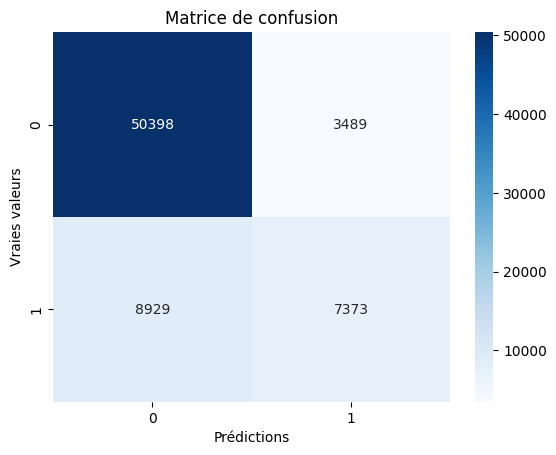

In [161]:
model_lgbm = clf_lgb.best_estimator_

y_pred_lgbm = model_lgbm.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred_lgbm)}')

print(f'AUC : {roc_auc_score(y_test, y_pred_lgbm)}')

print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_lgbm)}')

print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_lgbm)}')

print(f'Matrice de confusion')

confusion_matrix_graph = confusion_matrix(y_test, y_pred_lgbm)

sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")

plt.xlabel("Prédictions")

plt.ylabel("Vraies valeurs")

plt.title("Matrice de confusion")

plt.show()

Moyenne des scores pour chaque modèle :
polynomial_features    0.827981
lr_score               0.827355
lightgbm               0.827336
knn                    0.801224
decision_tree          0.705418
dtype: float64


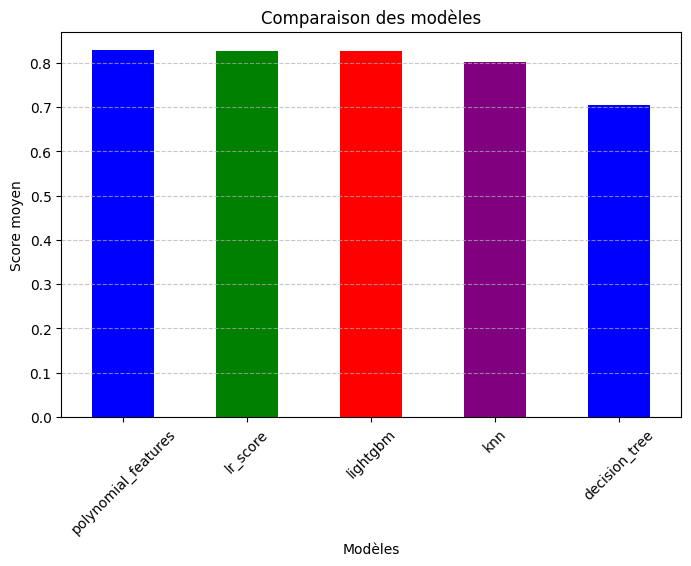

In [162]:
# Calcul de la moyenne des performances pour chaque modèle
mean_results = df_resultats.mean()

# Affichage des résultats triés par performance décroissante
mean_results = mean_results.sort_values(ascending=False)

print("Moyenne des scores pour chaque modèle :")
print(mean_results)

# Optionnel : affichage sous forme de graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
mean_results.plot(kind='bar', color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Modèles")
plt.ylabel("Score moyen")
plt.title("Comparaison des modèles")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()